In [1]:
# 필수 라이브러리 
!pip install --upgrade joblib==1.1.0
!pip install --upgrade scikit-learn==1.1.3
!pip install mglearn

# 한글깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.0/307.0 KB 7.3 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-learn 1.2.2 requires joblib>=1.1.1, but you have joblib 1.1.0 which is incompatible.
imbalanced-learn 0.10.1 requires joblib>=1.1.1, but you have joblib 1.1.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 9.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:

In [2]:
import logging

logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [3]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 

# 데이터 로드 & 분리

In [4]:
cancer = load_breast_cancer()

X_tr, X_te, y_tr, y_te = train_test_split(
    cancer.data, cancer.target, random_state=0
)

# Without Pipeline

## Scaling

In [5]:
scaler = MinMaxScaler().fit(X_tr)

In [6]:
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

## SVC

In [7]:
svm = SVC()

svm.fit(X_tr_scaled, y_tr)

SVC()

In [8]:
svm.score(X_te_scaled, y_te)

0.972027972027972

## GridSearchCV

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)

grid.fit(X_tr_scaled, y_tr)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

In [11]:
grid.best_score_

0.9812311901504789

In [12]:
grid.best_params_

{'C': 1, 'gamma': 1}

In [13]:
grid.score(X_te_scaled, y_te)

0.972027972027972

## 결과 분석

위의 모델 학습에서 스케일을 조정한 데이터를 사용해서 SVC의 매개변수에 대해 그리드 서치를 수행했습니다. 이상이 없는 학습인 것 같지만, 이 코드에는 교묘한 함정이 있습니다. `데이터의 최솟값과 최댓값을 계산할 때 학습을 위해 훈련 세트에 있는 모든 데이터를 사용하였습니다.`     
  
교차 검증의 각 분할에서 원본 훈련 세트 데이터의 어떤 부분은 훈련 폴드가 되고 어떤 부분은 검증 폴드가 됩니다. 즉 데이터 스케일을 조정할 때 검증 폴드에 들어 있는 정보까지 이미 사용했습니다.  

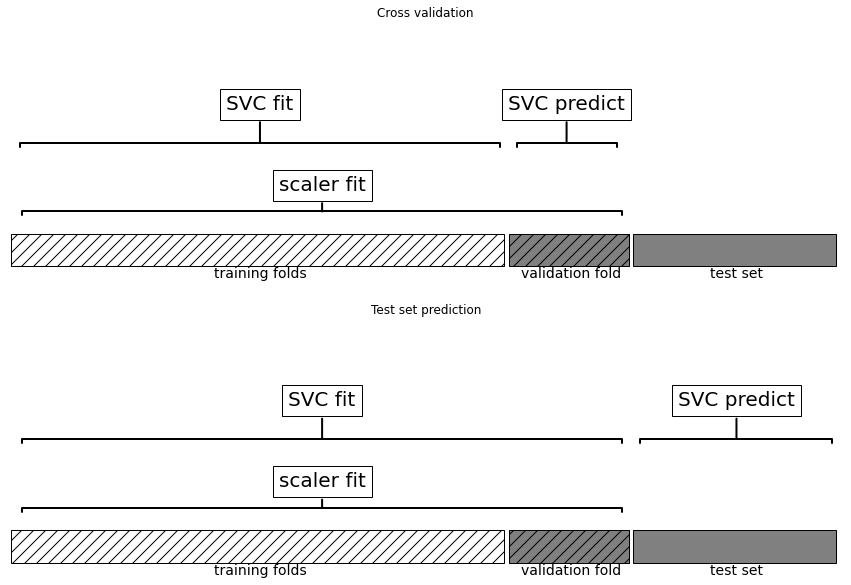

In [14]:
import mglearn

mglearn.plots.plot_improper_processing()

이 문제를 해결하려면 교차 검증의 분할이 모든 전처리 고정보다 앞서 이뤄져야 합니다. 이때 사용되는 모듈이 `Pipeline`입니다.

# With Pipeline

## SVC with scaling

In [15]:
from sklearn.pipeline import Pipeline

In [16]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svm', SVC())
])

pipe.fit은 첫 번째 단계(scaler)의 fit 메서드를 호출하여 훈련 데이터를 변환하고, 마지막으로 변환된 데이터에 SVM 모델을 훈련시킵니다.

In [17]:
pipe.fit(X_tr, y_tr)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

파이프라인에서 score 메서드를 호출하면, 먼저 scaler를 사용하여 테스트 데이터를 변환하고, 변환된 데이터에 SVM 모델의 score 메서드를 호출합니다.

In [18]:
pipe.score(X_te, y_te)

0.972027972027972

## GridSearchCV

In [19]:
param_grid = {
    'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)

grid.fit(X_tr_scaled, y_tr)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

In [20]:
grid.best_score_

0.9812311901504789

In [21]:
grid.best_params_

{'svm__C': 1, 'svm__gamma': 1}

In [22]:
grid.score(X_te_scaled, y_te)

0.972027972027972

## 결과 분석

이전에 본 그리드 서치와 다른 점은 교차 검증의 각 분할에 MinMaxScaler가 훈련 폴드에 매번 적용되고, 매개변수 검색 과정에 검증 폴더의 정보가 누설되지 않은 것을 알 수 있습니다.    

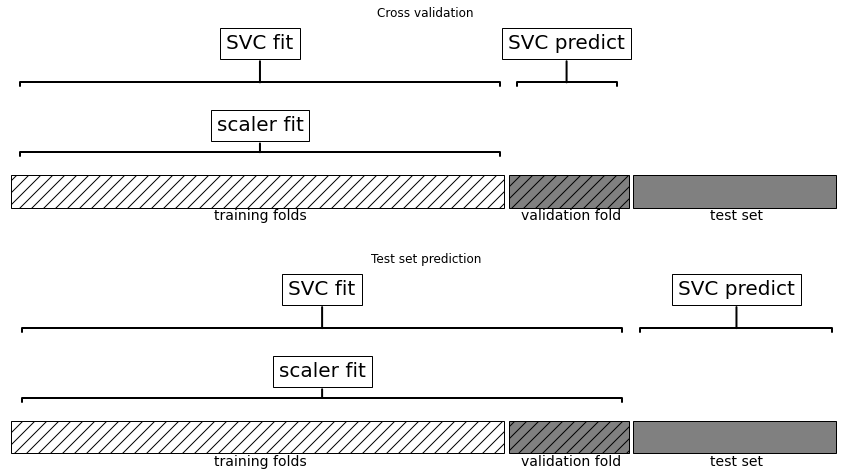

In [23]:
mglearn.plots.plot_proper_processing()

# Pipeline 심화

In [24]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## 데이터 로드

In [25]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
abalone = pd.read_csv(
    url, 
    sep=",", 
    names = ['sex', 'length', 'diameter', 'height', 
             'whole_weight', 'shucked_weight', 'viscera_weight', 
             'shell_weight', 'rings'], 
    header = None)

In [26]:
abalone.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## 숫자형 변수 전처리 파이프 라인

In [27]:
num_features = ["length", "whole_weight"]
num_transformer = Pipeline(
    steps = [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

## 범주형 변수 전처리 파이프 라인

In [28]:
cat_features = ["sex"]
cat_transformer = OneHotEncoder(handle_unknown="ignore")

## 전처리 파이프 라인 합치기

In [29]:
preprocessor = ColumnTransformer(
    transformers = [
        ("num", num_transformer, num_features), 
        ("cat", cat_transformer, cat_features)
    ]
)

## 전체 파이프라인

In [30]:
pipe = Pipeline(
    steps = [("preporcessor", preprocessor), ("regressor", LinearRegression())]
)

## 데이터 분리

In [31]:
X = abalone[["length", "whole_weight", "sex"]]
y = abalone["rings"]

X_tr, X_te, y_tr, y_te = train_test_split(X, y, 
                                          test_size=0.2, 
                                          random_state=42)

## 학습

In [32]:
from sklearn import set_config
set_config(display='diagram')

In [33]:
pipe.fit(X_tr, y_tr)

Pipeline(steps=[('preporcessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['length', 'whole_weight']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex'])])),
                ('regressor', LinearRegression())])

In [34]:
from sklearn.metrics import mean_absolute_percentage_error

In [35]:
y_pred = pipe.predict(X_te)

mean_absolute_percentage_error(y_te, y_pred)

0.1853230655055772